In [1]:
import pandas as pd

url = "Credit_Risk_Prediction.csv"
data = pd.read_csv(url)

In [2]:
#Convert the unit of Loan and MonthlyPaid to (k)
data["Loan"] = data["Loan"] / 1000
data["MonthlyPaid"] = data["MonthlyPaid"] / 1000

In [3]:
data["Gender"] = data["Gender"].map({"m":1 , "f":0})
data["Credit Risk Prediction"] = data["Credit Risk Prediction"].map({"Yes":1 , "No":0})

In [4]:
data

,Age,Loan,MonthlyPaid,Gender,Credit Risk Prediction
0,25,586.0,2.25,1,1
1,63,869.0,4.95,0,0
2,49,665.0,4.50,1,1
3,66,245.0,4.70,1,0
4,21,282.0,1.00,0,1
...,...,...,...,...,...
294,62,662.0,0.60,0,0
295,40,195.0,3.85,0,1
296,22,215.0,1.00,0,1
297,59,349.0,2.15,1,0


In [5]:
from sklearn.model_selection import train_test_split

x = data[["Age","Loan","MonthlyPaid","Gender"]]
y = data["Credit Risk Prediction"]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=87)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Standardization

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
import torch

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [9]:
from torch import nn

class LogisticRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=4,out_features=1,dtype=torch.float64)
        self.sigmoid = nn.Sigmoid() # https://docs.pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid

    def forward(self,x):
        return self.sigmoid(self.linear_layer(x))

In [10]:
torch.manual_seed(87)
model = LogisticRegressionModel()
model = model.to(device)
model, model.state_dict()

(LogisticRegressionModel(
   (linear_layer): Linear(in_features=4, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 OrderedDict([('linear_layer.weight',
               tensor([[-0.4710,  0.1380, -0.1459, -0.1397]], device='cuda:0',
                      dtype=torch.float64)),
              ('linear_layer.bias',
               tensor([-0.4544], device='cuda:0', dtype=torch.float64))]))

In [11]:
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [12]:
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [13]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [14]:
y_train = y_train.type(torch.double)   # https://docs.pytorch.org/docs/stable/tensor_attributes.html#torch.dtype
y_test = y_test.type(torch.double)

In [15]:
cost_fn = nn.BCELoss() # https://docs.pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
y_pred = model(x_train)
cost = cost_fn(y_pred,y_train)
print(model.state_dict()) #before
print(cost) #before

optimizer = torch.optim.SGD(params=model.parameters(),lr=1)
optimizer.zero_grad()
cost.backward()
optimizer.step()

y_pred = model(x_train)
cost = cost_fn(y_pred,y_train)
print(model.state_dict()) #after
print(cost) #after

OrderedDict([('linear_layer.weight', tensor([[-0.4710,  0.1380, -0.1459, -0.1397]], device='cuda:0',
       dtype=torch.float64)), ('linear_layer.bias', tensor([-0.4544], device='cuda:0', dtype=torch.float64))])
tensor(0.6555, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyBackward0>)
OrderedDict([('linear_layer.weight', tensor([[-0.6844, -0.0477,  0.0376, -0.0613]], device='cuda:0',
       dtype=torch.float64)), ('linear_layer.bias', tensor([-0.3352], device='cuda:0', dtype=torch.float64))])
tensor(0.5364, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyBackward0>)


In [16]:
#Loop
epochs = 1000

train_cost_hist = []
test_cost_hist = []
train_acc_hist = []
test_acc_hist = []

for epoch in range(epochs):
    model.train() # to indicate now is in train phase
    #model.eval() # to indicate in test phase
    
    y_pred = model(x_train)
    train_cost = cost_fn(y_pred, y_train)
    train_cost_hist.append(train_cost.cpu().detach().numpy()) # .detach().numpy() is convert the cost to numpy without track the gradient descent
    
    train_acc = (torch.round(y_pred)==y_train).sum() / len(y_train) * 100
    train_acc_hist.append(train_acc.cpu().detach().numpy())
    
    optimizer.zero_grad()
    train_cost.backward()
    optimizer.step()

    model.eval() #test phase
    with torch.inference_mode():   #no need to run gradient descent because it is in test phase
        test_pred = model(x_test)
        test_cost = cost_fn(test_pred,y_test)
        test_cost_hist.append(test_cost.cpu())
        
        test_acc = (torch.round(test_pred)==y_test).sum() / len(y_test) * 100
        test_acc_hist.append(test_acc.cpu())

    if epoch%100==0:
        print(f"{epoch:5} - train_cost : {train_cost: .4e} : test_cost : {test_cost : .4e} : train_acc : {train_acc:.2f}% : test_acc : {test_acc:.2f}%")

    0 - train_cost :  5.3640e-01 : test_cost :  4.4179e-01 : train_acc : 74.06% : test_acc : 86.67%
  100 - train_cost :  1.9309e-01 : test_cost :  1.2182e-01 : train_acc : 92.89% : test_acc : 95.00%
  200 - train_cost :  1.8765e-01 : test_cost :  1.1462e-01 : train_acc : 92.89% : test_acc : 95.00%
  300 - train_cost :  1.8661e-01 : test_cost :  1.1274e-01 : train_acc : 92.89% : test_acc : 95.00%
  400 - train_cost :  1.8634e-01 : test_cost :  1.1202e-01 : train_acc : 92.89% : test_acc : 95.00%
  500 - train_cost :  1.8627e-01 : test_cost :  1.1169e-01 : train_acc : 92.89% : test_acc : 95.00%
  600 - train_cost :  1.8624e-01 : test_cost :  1.1152e-01 : train_acc : 92.89% : test_acc : 95.00%
  700 - train_cost :  1.8623e-01 : test_cost :  1.1143e-01 : train_acc : 92.89% : test_acc : 95.00%
  800 - train_cost :  1.8623e-01 : test_cost :  1.1138e-01 : train_acc : 92.89% : test_acc : 95.00%
  900 - train_cost :  1.8623e-01 : test_cost :  1.1136e-01 : train_acc : 92.89% : test_acc : 95.00%


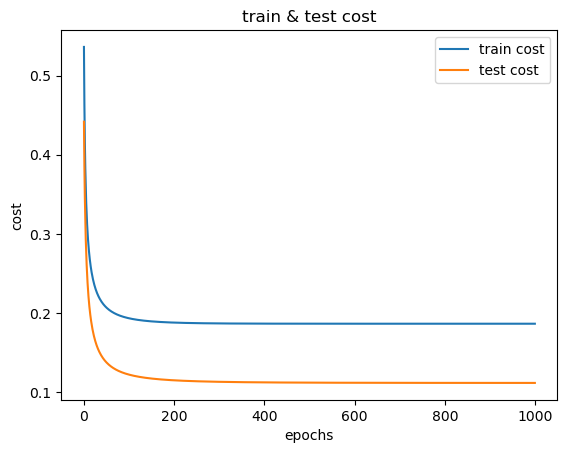

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(0,1000), train_cost_hist, label = "train cost")
plt.plot(range(0,1000), test_cost_hist, label = "test cost")
plt.title("train & test cost")
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend()
plt.show()

In [36]:
model.eval()
with torch.inference_mode():
    y_pred = model(x_test)
result = (torch.round(y_pred)==y_test).sum() / len(y_test) * 100
print(f"acc: {result:.2f}%")

acc: 95.00%


## Check data here

In [32]:
age = 65
loan = 300000 / 1000 #unit(k)
monthlypaid = 3500 / 1000 #unit(k)
gender = 0  #female

# x_realData = np.array([[age,loan,monthlypaid,gender]])
# x_realData = scaler.transform(x_realData)
# y_realData = (x_realData * w_final).sum(axis = 1) + b_final
# y_realData = sigmoid(y_realData)

model.eval()
with torch.inference_mode():
    x_realData = torch.tensor(scaler.transform([[age, loan, monthlypaid, gender]]),dtype=torch.float64)
    x_realData = x_realData.to(device)
    y_realData = round(model(x_realData).item(), 2)

if y_realData > 0.5:
    print("Congratulations, you may get the loan")
else:
    print("Sorry, your loan are rejected")

Sorry, your loan are rejected
